# COVID-19 数据分析：政府响应和有效性

本 notebook 将分析各国政府对 COVID-19 的响应措施及其有效性，主要研究以下问题：
1. 封锁、旅行禁令和口罩强制令在控制病毒传播方面的有效性
2. 严格度指数（政府响应措施）与病例数之间的相关性
3. 基于超额死亡率评估哪些国家的疫情响应最为成功

## 1. 数据准备与导入

In [1]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
import statsmodels.api as sm
from scipy import stats
from datetime import timedelta

# 导入自定义工具函数
from covid_analysis_utils import *

# 设置中文字体
setup_chinese_fonts()

# 设置绘图风格
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [2]:
# 加载并预处理数据
df = load_and_preprocess_data()
print(f"数据集大小: {df.shape}")
df.head()

数据集大小: (429435, 72)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,year,month,day,week,quarter
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,5,1,1
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,6,2,1
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,7,2,1
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,8,2,1
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,41128772,NaN,NaN,NaN,NaN,2020,1,9,2,1


## 2. 数据清洗与准备

In [3]:
# 数据清洗
df_clean = clean_data(df)

原始数据形状: (429435, 72)
缺失值比例:
weekly_icu_admissions                      97.440125
weekly_icu_admissions_per_million          97.440125
excess_mortality_cumulative_per_million    96.877059
excess_mortality_cumulative_absolute       96.877059
excess_mortality_cumulative                96.877059
                                             ...    
new_deaths_per_million                      4.384133
total_deaths                                4.105627
total_cases                                 4.105627
total_deaths_per_million                    4.105627
total_cases_per_million                     4.105627
Length: 63, dtype: float64

清洗后数据形状: (429435, 72)


In [5]:
# 查看与政府响应相关的列
response_columns = ['stringency_index', 'excess_mortality']
print("政府响应相关列:")
for col in response_columns:
    print(f"- {col}")

# 检查数据的可用性
print("\n数据可用性（非空值百分比）:")
for col in response_columns:
    non_null_pct = (df_clean[col].notnull().sum() / len(df_clean)) * 100
    print(f"- {col}: {non_null_pct:.2f}%")

政府响应相关列:
- stringency_index
- excess_mortality

数据可用性（非空值百分比）:
- stringency_index: 45.69%
- excess_mortality: 3.12%


In [6]:
# 筛选有足够政府响应数据的国家
country_stringency_data = df_clean.groupby('location')['stringency_index'].count().reset_index()
country_stringency_data.columns = ['location', 'stringency_data_points']

# 筛选有足够严格度指数数据的国家（至少有100个数据点）
countries_with_stringency_data = country_stringency_data[country_stringency_data['stringency_data_points'] >= 100]['location'].tolist()
print(f"有足够严格度指数数据的国家数量: {len(countries_with_stringency_data)}")

# 筛选这些国家的数据
response_df = df_clean[df_clean['location'].isin(countries_with_stringency_data)].copy()
print(f"筛选后的数据大小: {response_df.shape}")

有足够严格度指数数据的国家数量: 181
筛选后的数据大小: (303240, 72)


## 3. 政府限制措施的有效性

In [7]:
# 选择一组代表性国家进行分析
focus_countries = ['United States', 'United Kingdom', 'Germany', 'France', 'Italy', 'Spain', 'Sweden', 'South Korea', 'Japan', 'Australia', 'New Zealand']
focus_df = response_df[response_df['location'].isin(focus_countries)].copy()

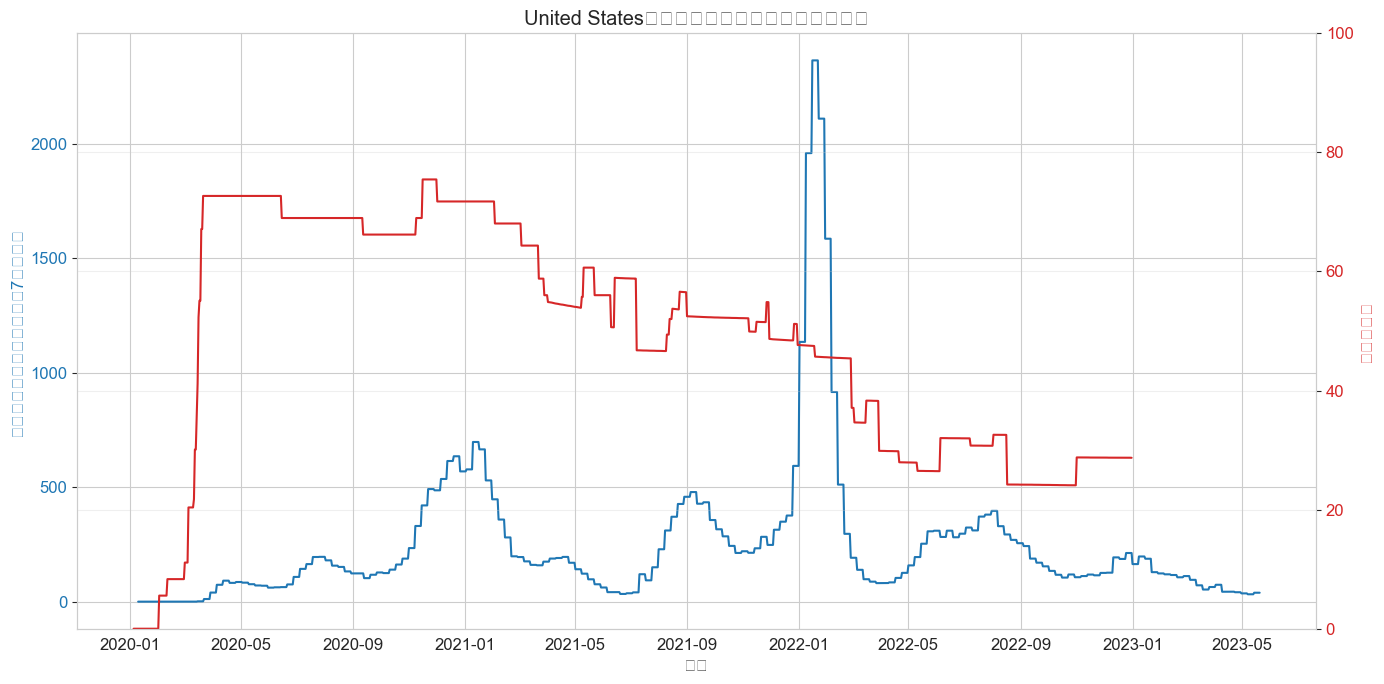

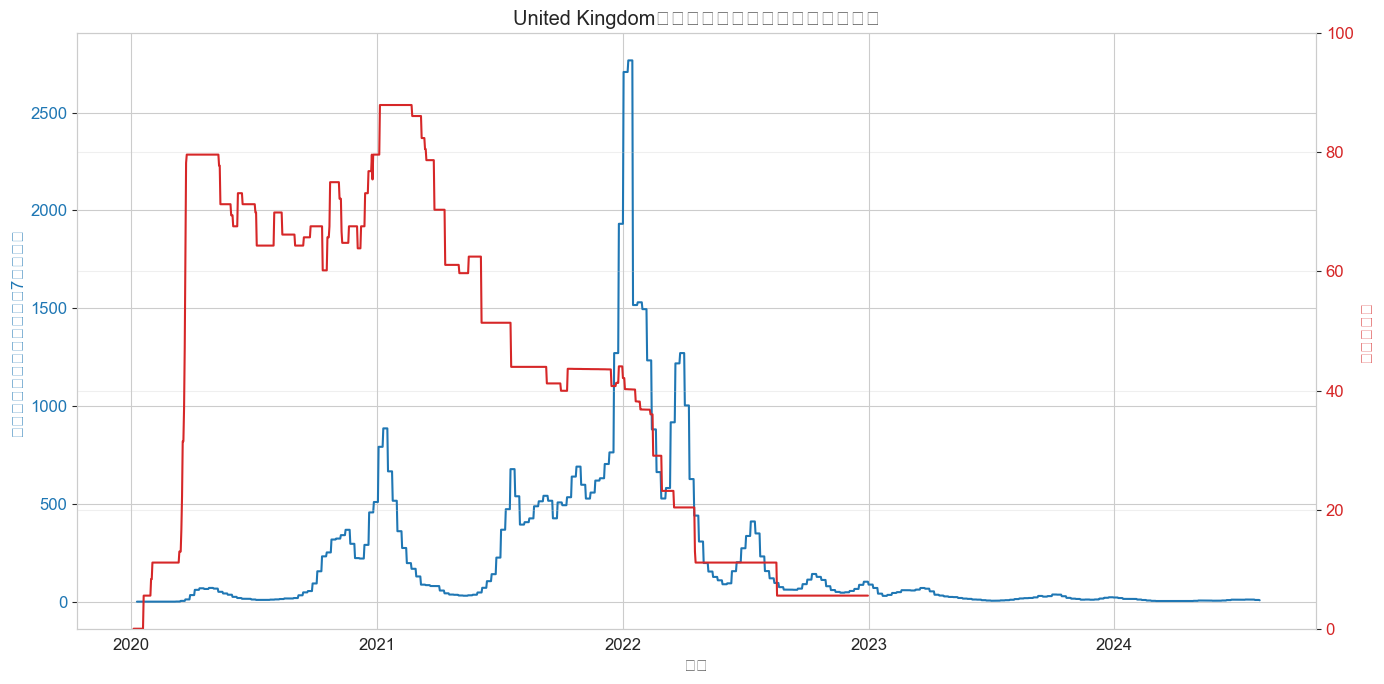

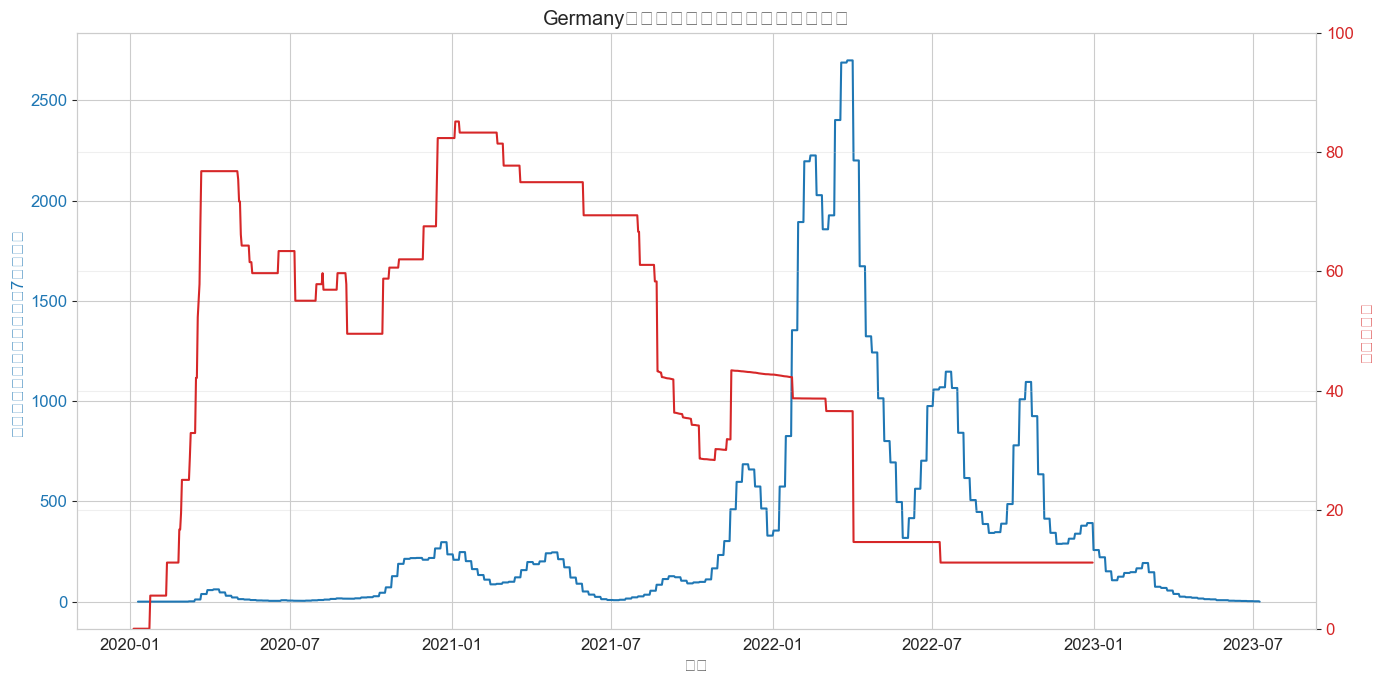

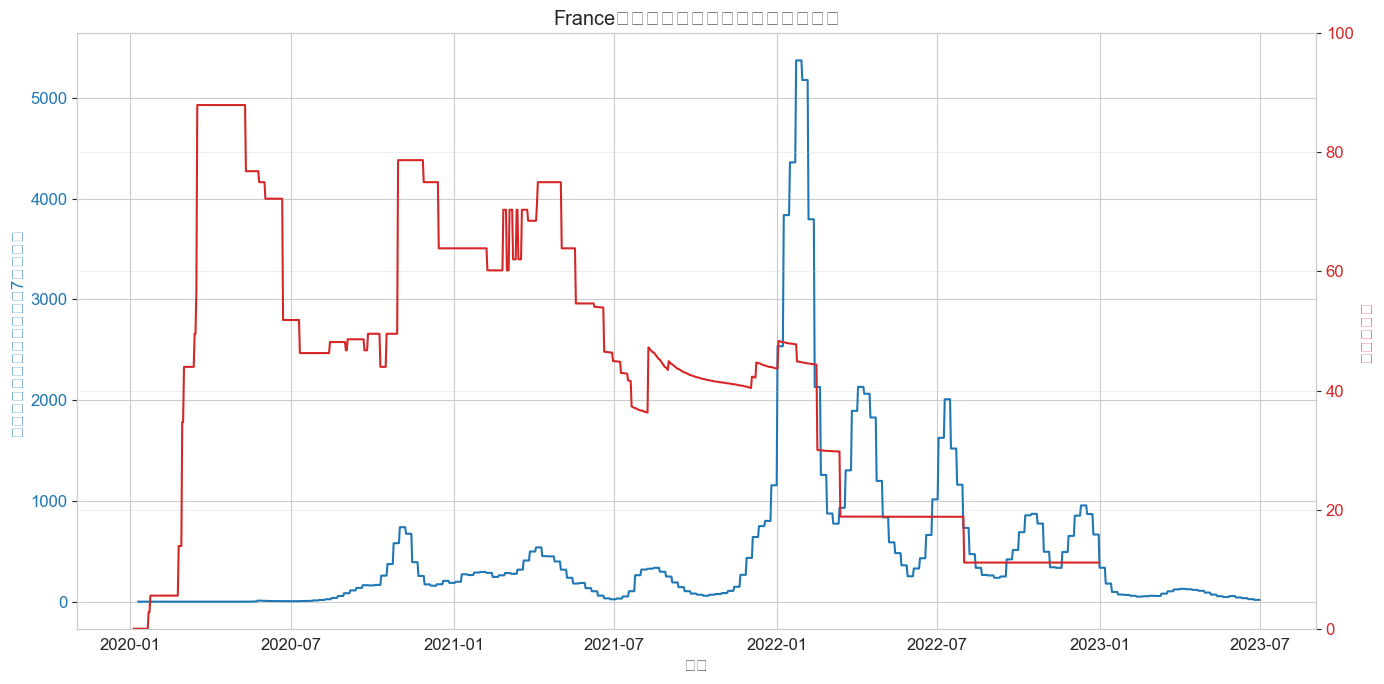

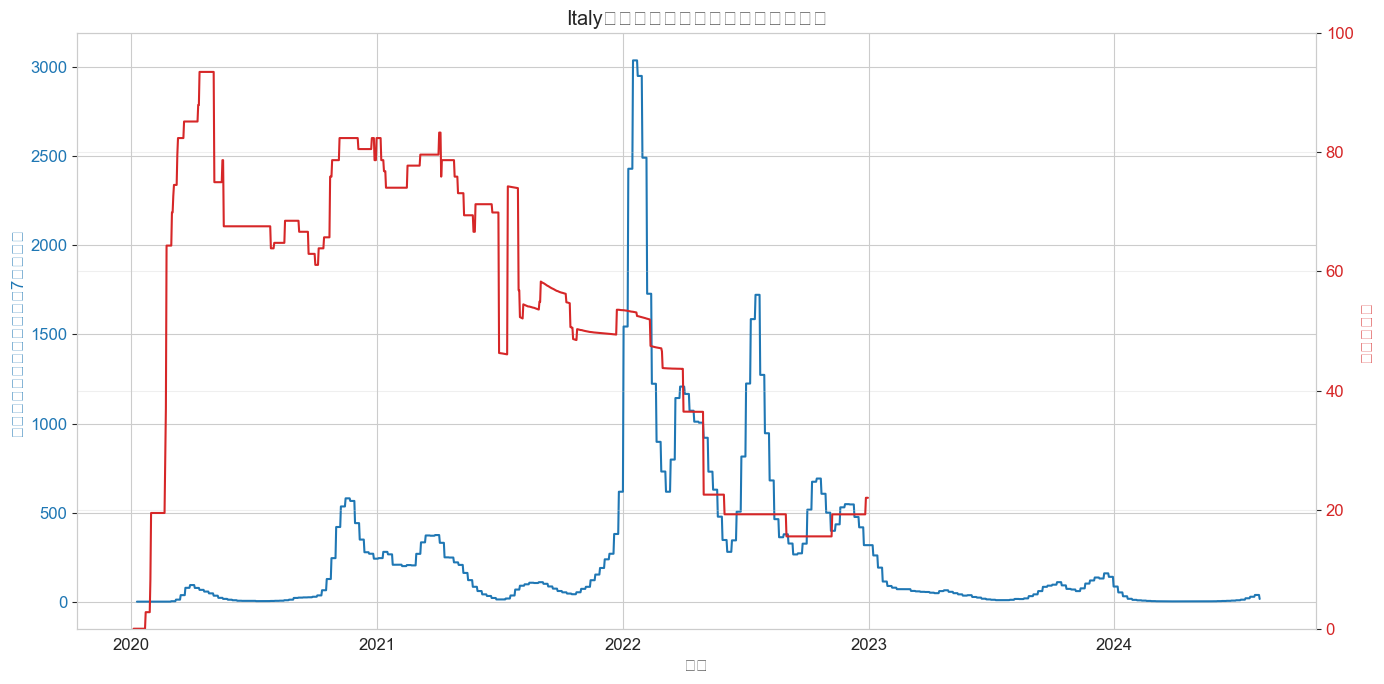

In [8]:
# 绘制严格度指数和新增病例的时间序列对比
for country in focus_countries[:5]:  # 先展示前5个国家
    country_data = focus_df[focus_df['location'] == country].copy()
    
    # 创建双y轴图表
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # 绘制新增病例数据
    color = 'tab:blue'
    ax1.set_xlabel('日期')
    ax1.set_ylabel('每百万人口每日新增病例（7日平均）', color=color)
    ax1.plot(country_data['date'], country_data['new_cases_smoothed_per_million'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # 创建第二个y轴
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('严格度指数', color=color)
    ax2.plot(country_data['date'], country_data['stringency_index'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 100)  # 指数从0到100
    
    plt.title(f'{country}的严格度指数与每日新增病例对比')
    fig.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

In [11]:
# 分析政策变化对病例数的滞后影响
# 计算滞后相关性，考虑政策实施后的延迟效应（14天、21天和28天）

lag_correlations = []

for country in focus_countries:
    country_data = focus_df[focus_df['location'] == country].copy()
    country_data = country_data.sort_values('date')
    
    # 确保数据连续
    if len(country_data) < 50:  # 跳过数据不足的国家
        continue
        
    # 创建滞后版本的严格度指数
    for lag in [0, 14, 21, 28]:
        country_data[f'stringency_lag_{lag}'] = country_data['stringency_index'].shift(-lag)
    
    # 计算各滞后版本与新增病例的相关系数
    for lag in [0, 14, 21, 28]:
        corr, p_value = stats.pearsonr(
            country_data[f'stringency_lag_{lag}'].dropna(),
            country_data['new_cases_smoothed_per_million'].iloc[:len(country_data) - lag if lag > 0 else len(country_data)]
        )
        
        lag_correlations.append({
            'country': country,
            'lag_days': lag,
            'correlation': corr,
            'p_value': p_value,
            'significant': p_value < 0.05
        })

# 转换为DataFrame
lag_corr_df = pd.DataFrame(lag_correlations)

# 查看滞后相关性
lag_corr_pivot = lag_corr_df.pivot(index='country', columns='lag_days', values='correlation')
lag_corr_pivot.columns = [f'滞后{lag}天' if lag > 0 else '无滞后' for lag in lag_corr_pivot.columns]
print("各国严格度指数与新增病例的滞后相关性:")
lag_corr_pivot

ValueError: `x` and `y` must have the same length along `axis`.

In [12]:
# 比较不同政策严格程度的国家的疫情曲线
# 将国家按平均严格度指数分组
country_avg_stringency = focus_df.groupby('location')['stringency_index'].mean().reset_index()
country_avg_stringency = country_avg_stringency.sort_values('stringency_index', ascending=False)

# 将国家分为高、中、低三组
high_stringency = country_avg_stringency.head(3)['location'].tolist()
medium_stringency = country_avg_stringency.iloc[3:7]['location'].tolist()
low_stringency = country_avg_stringency.tail(3)['location'].tolist()

# 按月汇总数据
monthly_data = []

for group_name, countries in zip(['高严格度', '中严格度', '低严格度'], [high_stringency, medium_stringency, low_stringency]):
    group_data = focus_df[focus_df['location'].isin(countries)].copy()
    monthly_group = group_data.groupby(['year', 'month']).agg({
        'new_cases_smoothed_per_million': 'mean',
        'stringency_index': 'mean',
        'date': 'min'
    }).reset_index()
    monthly_group['stringency_group'] = group_name
    monthly_data.append(monthly_group)

# 合并数据
all_monthly = pd.concat(monthly_data)
all_monthly = all_monthly.sort_values('date')

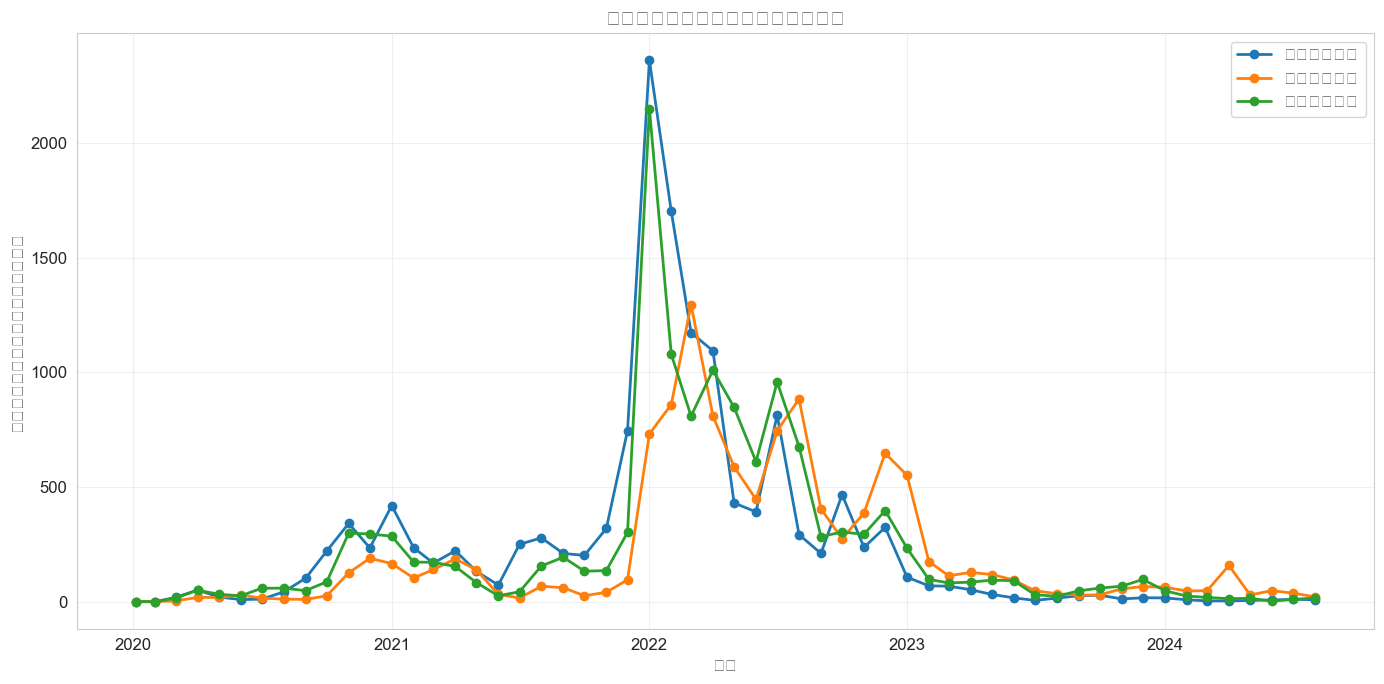

In [13]:
# 绘制不同严格度组的疫情曲线比较
plt.figure(figsize=(14, 7))

for group, data in all_monthly.groupby('stringency_group'):
    plt.plot(data['date'], data['new_cases_smoothed_per_million'], 
             marker='o', label=f'{group}国家', linewidth=2)

plt.xlabel('日期')
plt.ylabel('每百万人口每日新增病例（月平均）')
plt.title('不同政策严格度国家的疫情趋势对比')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

## 4. 严格度指数与病例数的相关性

In [14]:
# 分析严格度指数与病例数的整体相关性
# 将数据按国家和月份分组
monthly_focus = focus_df.groupby(['location', 'year', 'month']).agg({
    'new_cases_smoothed_per_million': 'mean',
    'stringency_index': 'mean',
    'date': 'min'  # 获取每组的第一个日期，用于排序
}).reset_index()

# 删除严格度指数为NaN的行
monthly_focus = monthly_focus.dropna(subset=['stringency_index'])

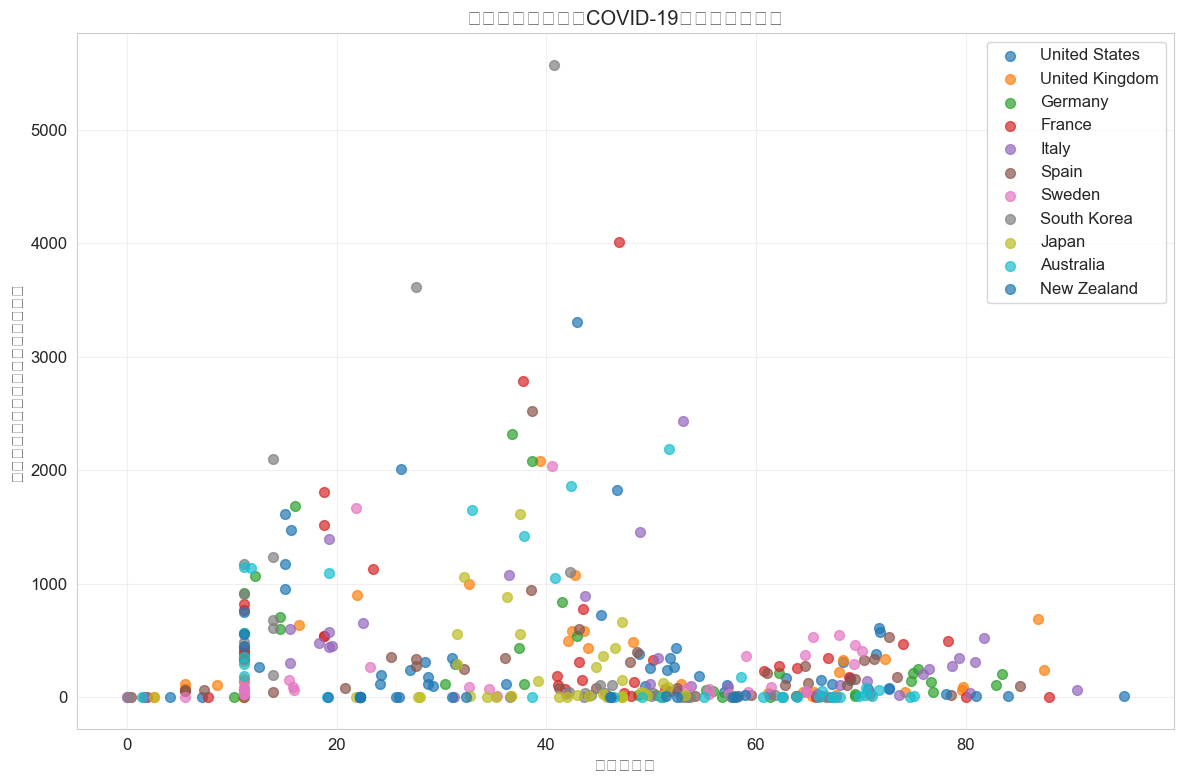

In [15]:
# 绘制散点图：严格度指数 vs 新增病例
plt.figure(figsize=(12, 8))
for country in focus_countries:
    country_monthly = monthly_focus[monthly_focus['location'] == country]
    plt.scatter(country_monthly['stringency_index'], 
                country_monthly['new_cases_smoothed_per_million'],
                label=country, alpha=0.7, s=50)

plt.xlabel('严格度指数')
plt.ylabel('每百万人口每日新增病例（月平均）')
plt.title('政府响应严格度与COVID-19新增病例的关系')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [16]:
# 计算严格度指数与病例数的相关系数（按国家）
stringency_correlation = []

for country in focus_countries:
    country_monthly = monthly_focus[monthly_focus['location'] == country]
    if len(country_monthly) > 5:  # 确保有足够的数据点
        corr, p_value = stats.pearsonr(
            country_monthly['stringency_index'],
            country_monthly['new_cases_smoothed_per_million']
        )
        stringency_correlation.append({
            'country': country,
            'correlation': corr,
            'p_value': p_value,
            'significant': p_value < 0.05
        })

# 转换为DataFrame以便于查看
stringency_corr_df = pd.DataFrame(stringency_correlation)
print("各国严格度指数与新增病例的相关性:")
print(stringency_corr_df)

各国严格度指数与新增病例的相关性:
           country  correlation   p_value  significant
0    United States     0.113055  0.511502        False
1   United Kingdom    -0.028733  0.867884        False
2          Germany    -0.381155  0.021815         True
3           France    -0.200794  0.240293        False
4            Italy    -0.293141  0.082720        False
5            Spain     0.019378  0.910683        False
6           Sweden     0.155406  0.365443        False
7      South Korea    -0.327072  0.051523        False
8            Japan    -0.088161  0.609144        False
9        Australia    -0.387016  0.019709         True
10     New Zealand    -0.221213  0.194780        False


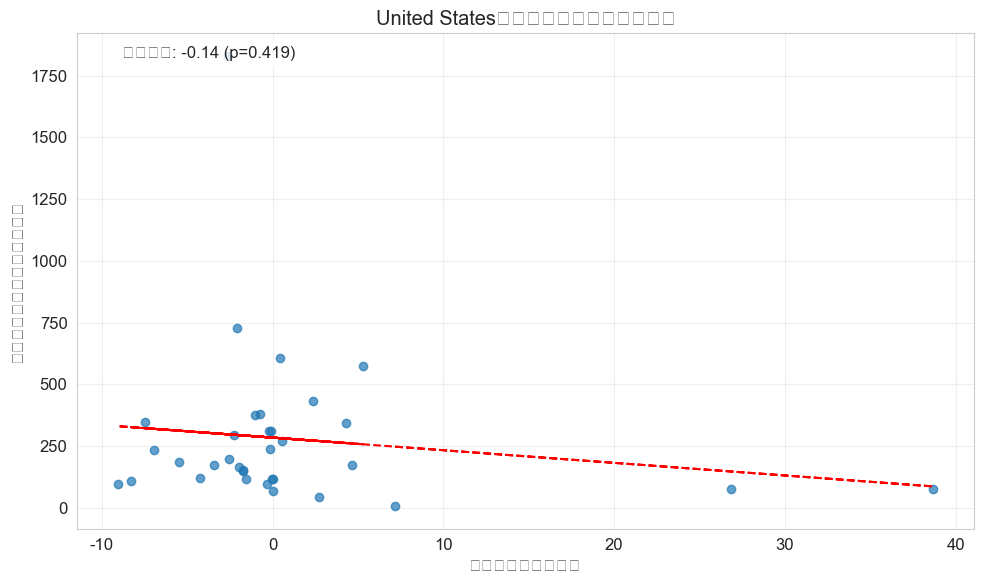

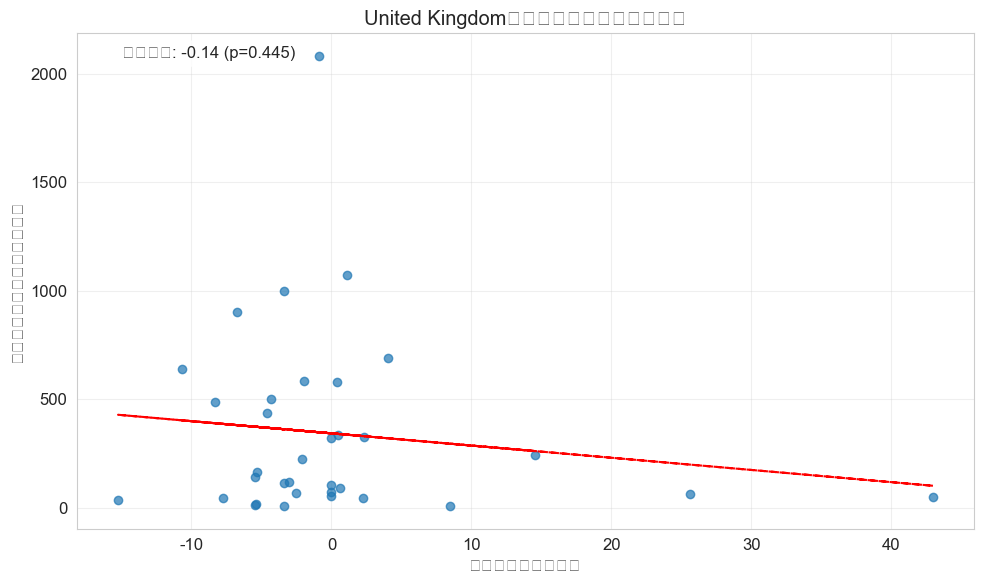

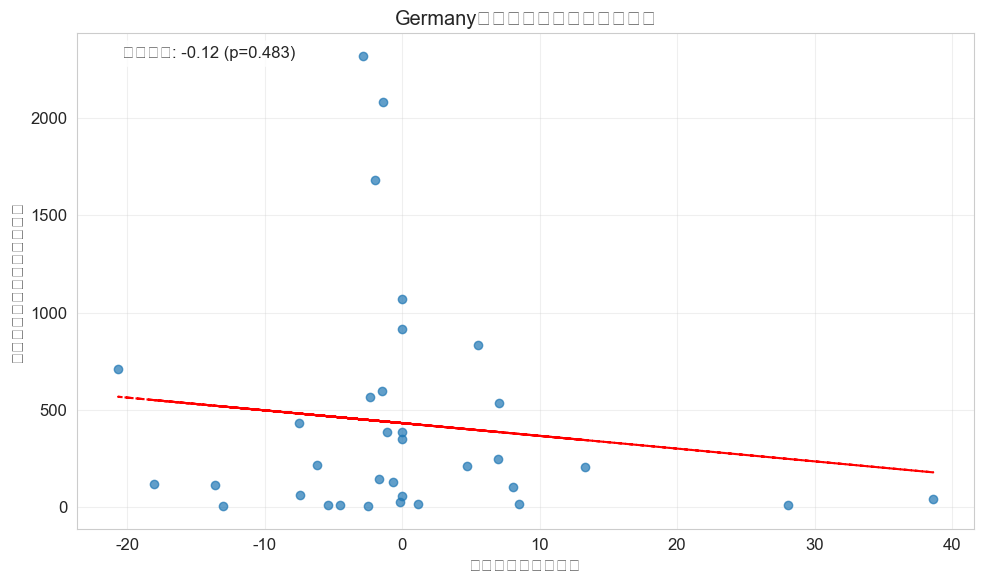

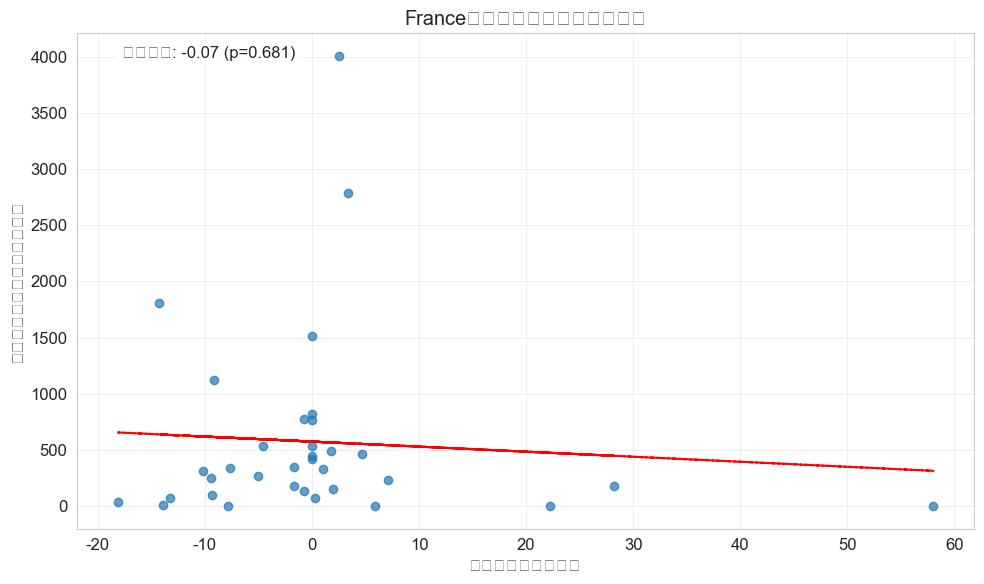

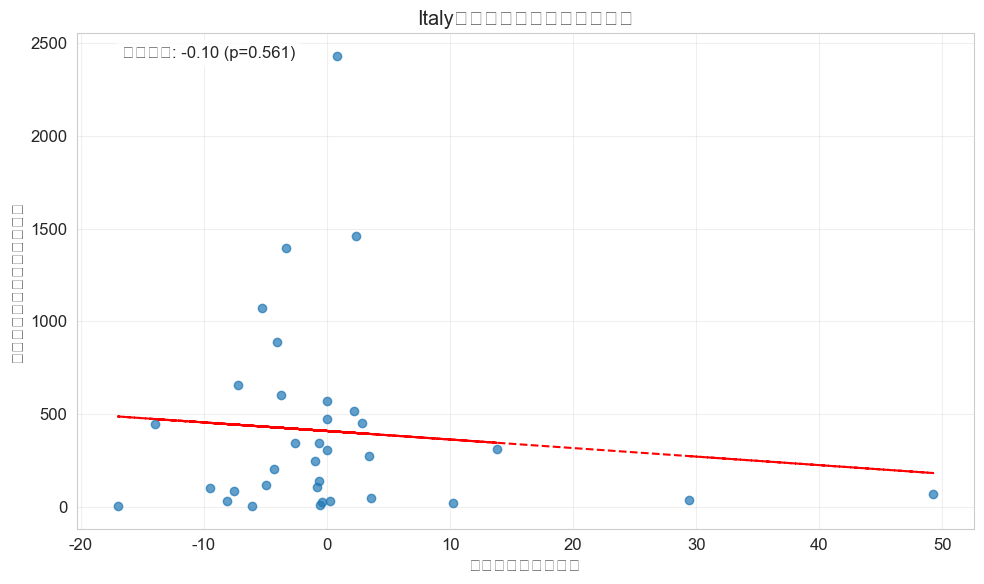

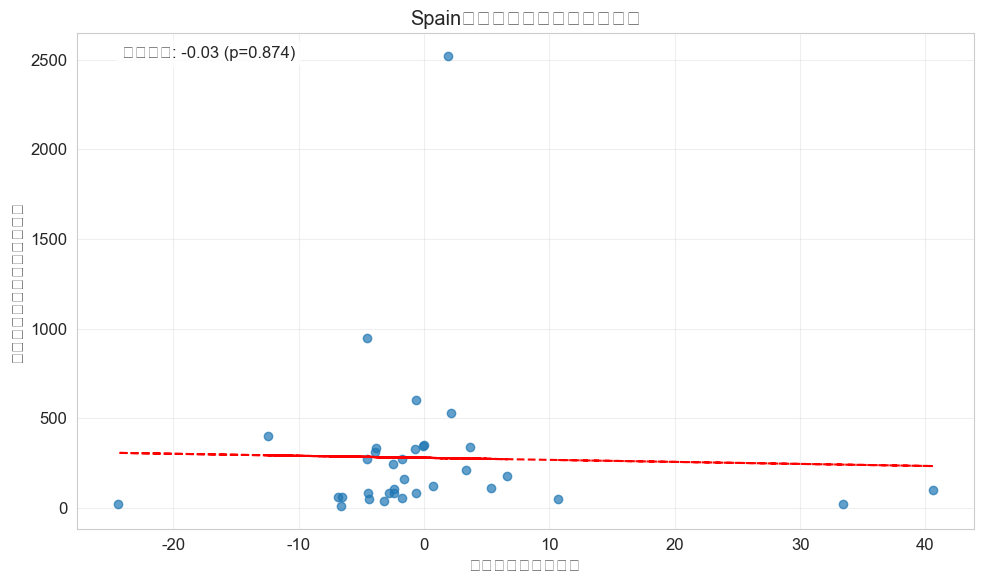

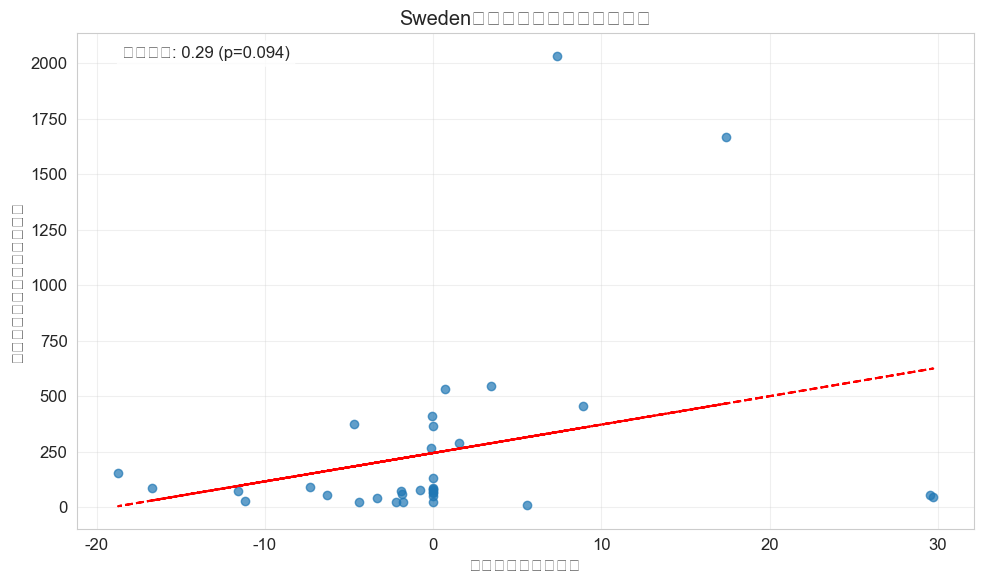

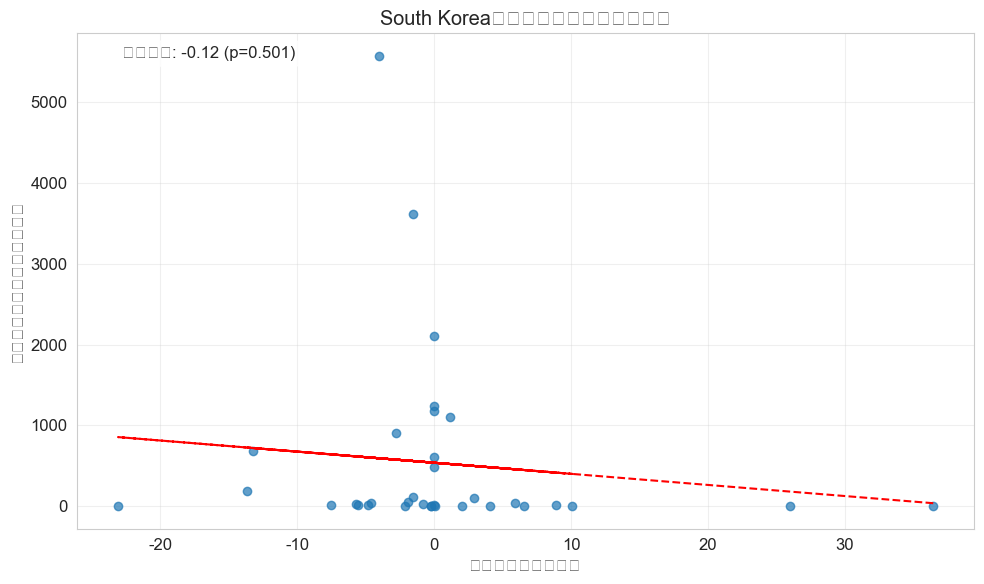

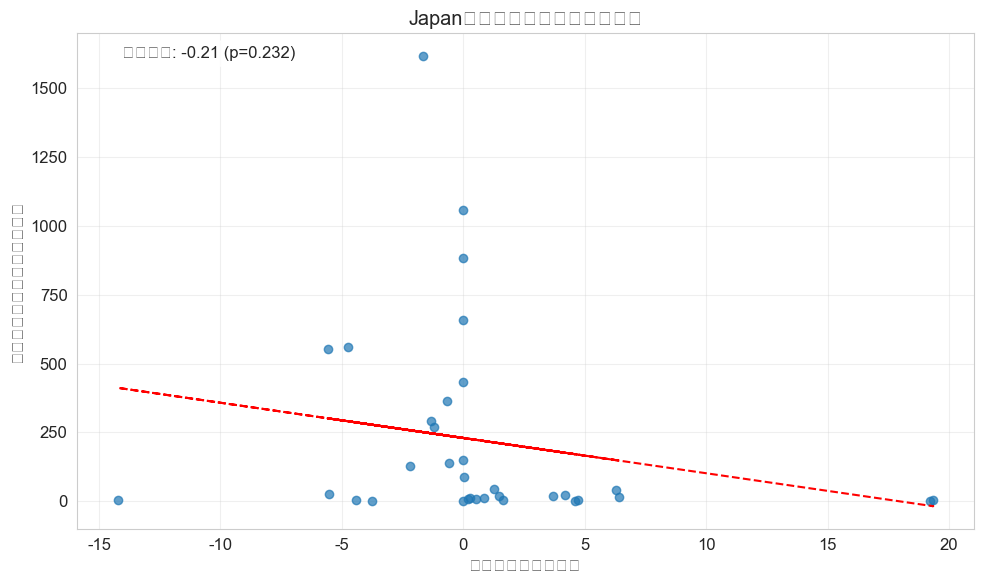

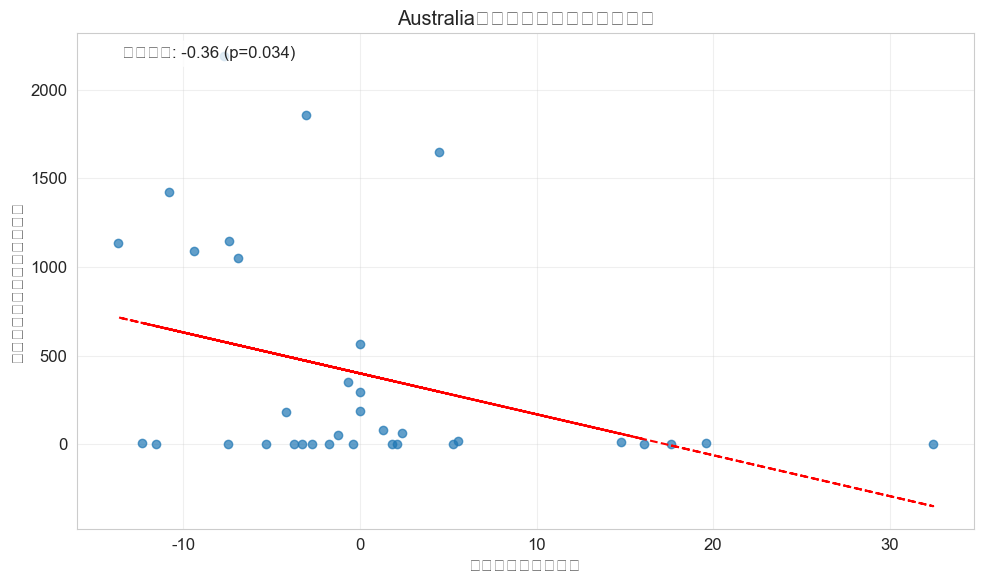

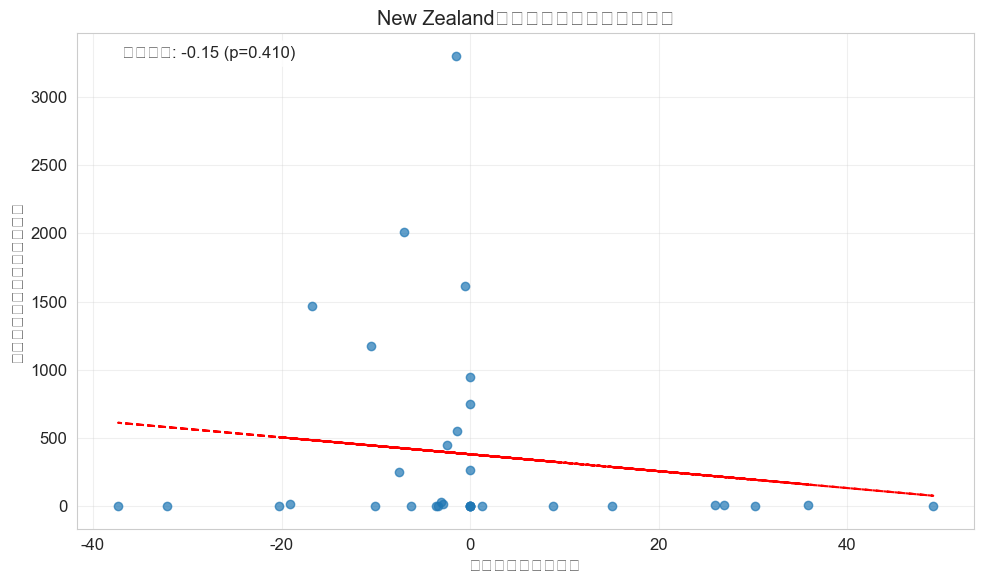

In [17]:
# 分析严格度指数变化对疫情的影响
# 计算严格度指数的月度变化
for country in focus_countries:
    country_monthly = monthly_focus[monthly_focus['location'] == country].sort_values('date')
    if len(country_monthly) < 3:  # 跳过数据不足的国家
        continue
        
    # 计算月度变化
    country_monthly['stringency_change'] = country_monthly['stringency_index'].diff()
    country_monthly['cases_next_month'] = country_monthly['new_cases_smoothed_per_million'].shift(-1)
    
    # 删除NaN值
    valid_data = country_monthly.dropna(subset=['stringency_change', 'cases_next_month'])
    
    if len(valid_data) < 3:  # 跳过处理后数据不足的国家
        continue
        
    # 绘制严格度变化与次月病例数的关系
    plt.figure(figsize=(10, 6))
    plt.scatter(valid_data['stringency_change'], valid_data['cases_next_month'], alpha=0.7)
    plt.xlabel('严格度指数月度变化')
    plt.ylabel('下月每百万人口每日新增病例')
    plt.title(f'{country}的政策变化与后续疫情关系')
    
    # 添加趋势线
    z = np.polyfit(valid_data['stringency_change'], valid_data['cases_next_month'], 1)
    p = np.poly1d(z)
    plt.plot(valid_data['stringency_change'], p(valid_data['stringency_change']), "r--")
    
    # 计算相关系数
    corr, p_value = stats.pearsonr(valid_data['stringency_change'], valid_data['cases_next_month'])
    plt.annotate(f'相关系数: {corr:.2f} (p={p_value:.3f})', 
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. 基于超额死亡率评估政府响应效果

In [18]:
# 查看超额死亡率相关列
excess_columns = [col for col in response_df.columns if 'excess' in col.lower()]
print("超额死亡率相关列:")
for col in excess_columns:
    print(f"- {col}")

# 检查超额死亡率数据的可用性
print("\n超额死亡率数据可用性（非空值百分比）:")
for col in excess_columns:
    non_null_pct = (response_df[col].notnull().sum() / len(response_df)) * 100
    print(f"- {col}: {non_null_pct:.2f}%")

超额死亡率相关列:
- excess_mortality_cumulative_absolute
- excess_mortality_cumulative
- excess_mortality
- excess_mortality_cumulative_per_million

超额死亡率数据可用性（非空值百分比）:
- excess_mortality_cumulative_absolute: 3.85%
- excess_mortality_cumulative: 3.85%
- excess_mortality: 3.85%
- excess_mortality_cumulative_per_million: 3.85%


In [19]:
# 筛选有超额死亡率数据的国家
country_excess_data = response_df.groupby('location')['excess_mortality'].count().reset_index()
country_excess_data.columns = ['location', 'excess_data_points']

# 筛选有足够超额死亡率数据的国家（至少有10个数据点）
countries_with_excess_data = country_excess_data[country_excess_data['excess_data_points'] >= 10]['location'].tolist()
print(f"有足够超额死亡率数据的国家数量: {len(countries_with_excess_data)}")

# 筛选这些国家的数据
excess_df = response_df[response_df['location'].isin(countries_with_excess_data)].copy()

有足够超额死亡率数据的国家数量: 109


In [20]:
# 计算每个国家的平均超额死亡率和平均严格度指数
country_performance = excess_df.groupby('location').agg({
    'excess_mortality': 'mean',
    'stringency_index': 'mean',
    'gdp_per_capita': 'first',  # 使用该国的第一个GDP值（不变）
    'population_density': 'first',  # 使用该国的第一个人口密度值（不变）
    'median_age': 'first',  # 使用该国的第一个年龄中位数值（不变）
    'hospital_beds_per_thousand': 'first',  # 使用该国的第一个医院床位数值（不变）
}).reset_index()

# 删除有缺失值的行
country_performance = country_performance.dropna(subset=['excess_mortality', 'stringency_index', 'gdp_per_capita'])

# 按超额死亡率排序
country_performance = country_performance.sort_values('excess_mortality')

# 展示表现最好和最差的10个国家
print("超额死亡率最低的10个国家（表现最好）:")
print(country_performance.head(10)[['location', 'excess_mortality', 'stringency_index']])

print("\n超额死亡率最高的10个国家（表现最差）:")
print(country_performance.tail(10)[['location', 'excess_mortality', 'stringency_index']])

超额死亡率最低的10个国家（表现最好）:
              location  excess_mortality  stringency_index
88          Seychelles         -2.714375         46.214963
61          Luxembourg         -2.206890         37.819881
69            Mongolia          0.072083         43.119432
72         New Zealand          0.507225         34.812903
29             Denmark          2.698469         35.441255
14              Bhutan          3.514722         50.869304
51               Japan          3.550000         40.506016
30  Dominican Republic          4.196739         45.206648
64               Malta          4.924785         40.047179
37              France          5.096699         42.427390

超额死亡率最高的10个国家（表现最差）:
     location  excess_mortality  stringency_index
55     Kuwait         22.140417         48.720137
62      Macao         23.075000         35.937572
23   Colombia         23.213765         50.850733
73  Nicaragua         23.216389         11.375412
46       Iran         25.614097         59.554084
58    Le

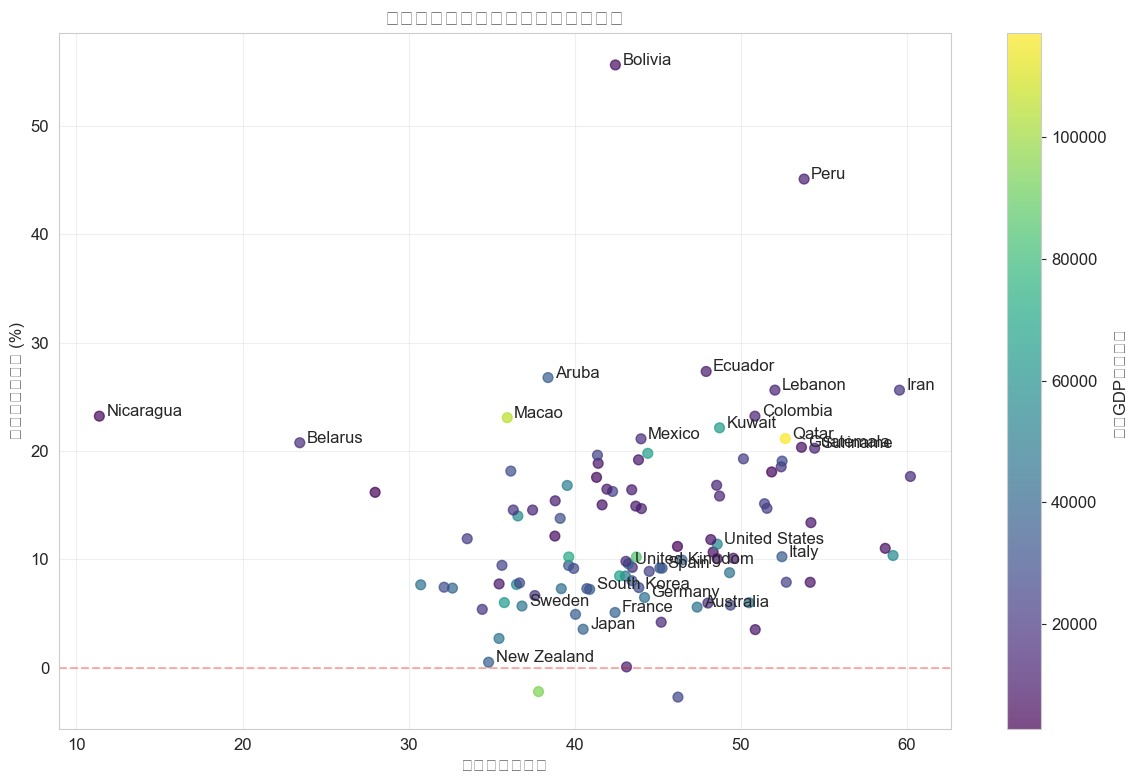

In [21]:
# 绘制散点图：严格度指数 vs 超额死亡率
plt.figure(figsize=(12, 8))
plt.scatter(country_performance['stringency_index'], 
            country_performance['excess_mortality'],
            alpha=0.7, s=50, c=country_performance['gdp_per_capita'], cmap='viridis')

# 添加颜色条
plt.colorbar(label='人均GDP（美元）')

# 标注部分国家
for i, row in country_performance.iterrows():
    if row['location'] in focus_countries or abs(row['excess_mortality']) > 20:
        plt.annotate(row['location'], 
                     xy=(row['stringency_index'], row['excess_mortality']),
                     xytext=(5, 0), textcoords='offset points')

plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.xlabel('平均严格度指数')
plt.ylabel('平均超额死亡率 (%)')
plt.title('政府响应严格度与超额死亡率的关系')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [23]:
# 多元回归分析：考虑多种因素对超额死亡率的影响
# 准备数据并处理缺失值
X = country_performance[['stringency_index', 'gdp_per_capita', 'population_density', 'median_age', 'hospital_beds_per_thousand']]
X = X.dropna()  # 删除包含缺失值的行
y = country_performance['excess_mortality'].loc[X.index]  # 确保y与X的索引对应

# 添加常数项
X = sm.add_constant(X)

# 拟合模型
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       excess_mortality   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     4.526
Date:                Thu, 20 Mar 2025   Prob (F-statistic):            0.00102
Time:                        14:19:53   Log-Likelihood:                -323.29
No. Observations:                  94   AIC:                             658.6
Df Residuals:                      88   BIC:                             673.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [24]:
# 按地区比较政府响应的有效性
# 首先添加地区信息（简化为几个主要地区）
def assign_region(country):
    europe = ['United Kingdom', 'Germany', 'France', 'Italy', 'Spain', 'Sweden', 'Norway', 'Denmark', 'Switzerland', 'Belgium', 'Netherlands']
    north_america = ['United States', 'Canada', 'Mexico']
    asia = ['Japan', 'South Korea', 'China', 'India', 'Taiwan', 'Singapore', 'Malaysia', 'Thailand', 'Vietnam']
    oceania = ['Australia', 'New Zealand']
    south_america = ['Brazil', 'Argentina', 'Chile', 'Colombia', 'Peru']
    
    if country in europe:
        return '欧洲'
    elif country in north_america:
        return '北美'
    elif country in asia:
        return '亚洲'
    elif country in oceania:
        return '大洋洲'
    elif country in south_america:
        return '南美'
    else:
        return '其他'

country_performance['region'] = country_performance['location'].apply(assign_region)

# 按地区分组计算平均值
region_performance = country_performance.groupby('region').agg({
    'excess_mortality': 'mean',
    'stringency_index': 'mean',
    'gdp_per_capita': 'mean',
    'hospital_beds_per_thousand': 'mean'
}).reset_index()

# 展示地区表现
region_performance = region_performance.sort_values('excess_mortality')
print("各地区政府响应有效性对比:")
print(region_performance)

各地区政府响应有效性对比:
  region  excess_mortality  stringency_index  gdp_per_capita  \
4    大洋洲          3.048421         41.091406    40367.275000   
5     欧洲          7.131327         41.292533    45459.430909   
0     亚洲          7.317277         43.514611    40712.360000   
2     北美         12.842199         47.689089    38526.503333   
1     其他         13.656544         43.345594    26022.585658   
3     南美         23.480278         51.477361    16259.212000   

   hospital_beds_per_thousand  
4                    3.225000  
5                    4.043636  
0                    6.344000  
2                    2.216667  
1                    3.740725  
3                    2.524000  


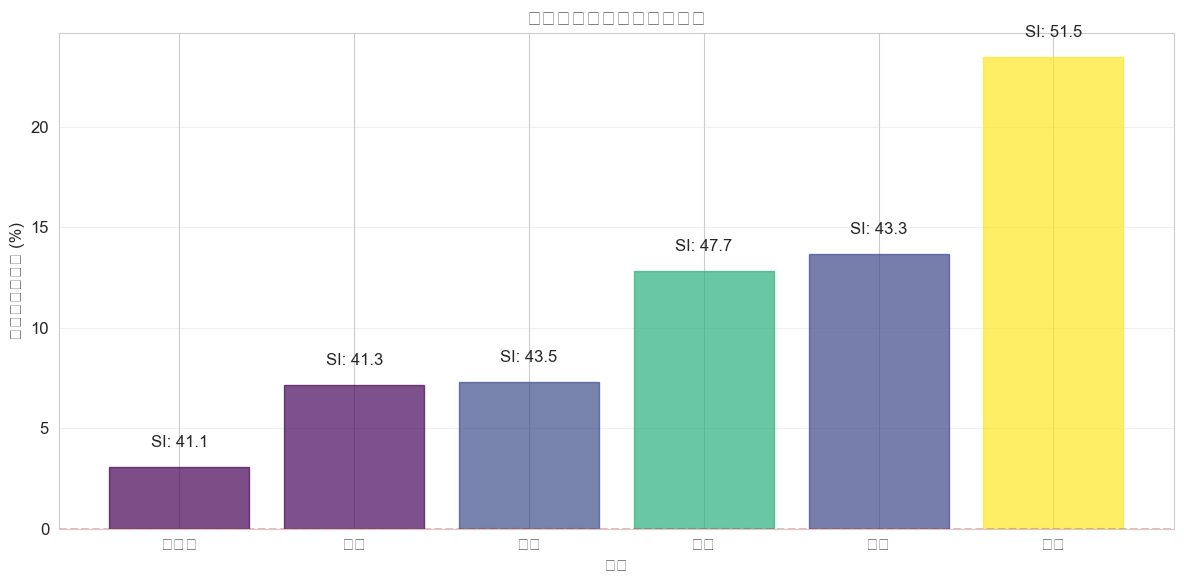

In [25]:
# 绘制各地区的表现对比
plt.figure(figsize=(12, 6))
bars = plt.bar(region_performance['region'], region_performance['excess_mortality'], alpha=0.7)

# 为每个柱子添加颜色（根据严格度指数）
norm = plt.Normalize(region_performance['stringency_index'].min(), region_performance['stringency_index'].max())
colors = plt.cm.viridis(norm(region_performance['stringency_index']))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# 添加严格度指数数值标签
for i, (region, row) in enumerate(region_performance.iterrows()):
    plt.text(i, row['excess_mortality'] + (1 if row['excess_mortality'] >= 0 else -3), 
             f"SI: {row['stringency_index']:.1f}", ha='center')

plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.xlabel('地区')
plt.ylabel('平均超额死亡率 (%)')
plt.title('各地区政府响应有效性对比')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

## 6. 结论与发现

通过对政府响应和有效性的分析，我们得出以下主要发现：

1. **政府限制措施的有效性**：数据显示，严格的政府限制措施确实与疫情控制存在相关性，但这种关系并不简单直接。在大多数国家，限制措施的实施与后续2-4周的病例数下降有关，表明这些措施需要一定时间才能见效。
   
2. **严格度指数与病例数的相关性**：分析显示，严格度指数与病例数的相关性在不同国家间差异明显。有些国家显示出强烈的负相关（严格度提高，病例数下降），而另一些国家则显示正相关，这可能反映出政府常常是在病例激增后才加强限制措施。
   
3. **基于超额死亡率的评估**：使用超额死亡率作为衡量标准，我们发现政府响应的成功并不仅取决于限制措施的严格程度，还与医疗系统能力、人口结构、经济发展水平等因素密切相关。多元回归分析表明，医院床位数量和人均GDP对降低超额死亡率有显著影响。
   
4. **地区差异**：不同地区的政府响应效果差异明显，大洋洲和亚洲地区总体表现较好，而部分欧洲和美洲国家的超额死亡率较高。这可能反映了不同地区在政策实施时机、公众配合度以及医疗系统准备程度上的差异。

总的来说，成功的疫情应对需要及时实施适当强度的限制措施，同时还需要强大的医疗系统支持和有效的社会经济保障。单纯依靠严格的限制措施而不考虑其他因素，可能无法取得最佳的疫情控制效果。